# Inception V0.1
전체 finetuning

# Import

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import KFold

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

사용 디바이스: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


# Data Load

In [ ]:
# 데이터 경로
base_dir = r'c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj'
driver_csv_path = os.path.join(base_dir, 'data', 'driver_imgs_list.csv')
train_dir = os.path.join(base_dir, 'data', 'imgs', 'train')
test_dir = os.path.join(base_dir, 'data', 'imgs', 'test')

# 하이퍼파라미터
img_size = 299  # Inception V4 입력 크기
batch_size = 32
num_classes = 10
num_epochs = 50
learning_rate = 0.001
num_workers = 0
version = "0.1"

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
print(f"이미지 크기: {img_size}x{img_size}")
print(f"배치 크기: {batch_size}")

Train directory: c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj\data\imgs\train
Test directory: c:\Users\USER\PycharmProjects\DeepLearning-Term-Proj\data\imgs\test
이미지 크기: 299x299
배치 크기: 32


고유 운전자 수: 26명
운전자 목록: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


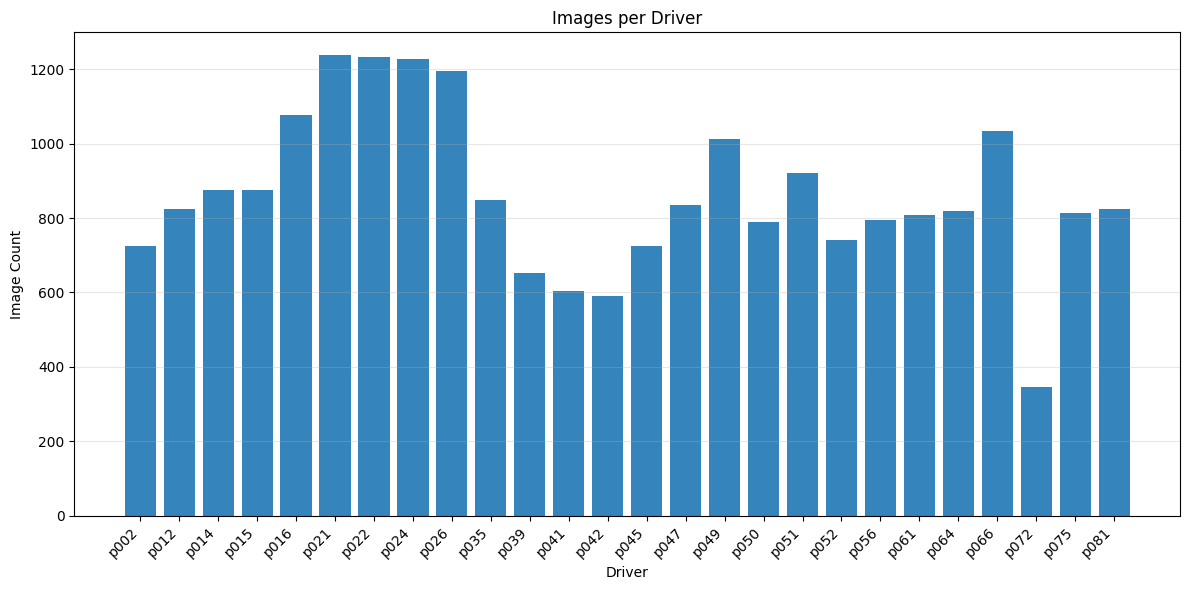

In [3]:
driver_df = pd.read_csv(driver_csv_path)

print(f"고유 운전자 수: {driver_df['subject'].nunique()}명")
print(f"운전자 목록: {sorted(driver_df['subject'].unique())}")

driver_counts = driver_df['subject'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(driver_counts.index.astype(str), driver_counts.values, color='C0', alpha=0.9)
plt.xlabel('Driver')
plt.ylabel('Image Count')
plt.title('Images per Driver')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 5-Fold Cross Validation
fold별 운전자 목록을 미리 나누긴 하되 초기 실험 단계에서는 한 폴드(fold 2, 학습 데이터가 가장 많아서..)만 사용하고 이후 마무리 단계에서 전체 폴드 다 돌려서 일반화 성능 끌어올리는 방향으로 진행.

## split train data into 5 folds

In [4]:
all_drivers = sorted(driver_df['subject'].unique())

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_splits = []
for fold_idx, (train_indices, val_indices) in enumerate(kfold.split(all_drivers)):
	train_drivers = [all_drivers[i] for i in train_indices]
	val_drivers = [all_drivers[i] for i in val_indices]

	fold_splits.append({
		'fold': fold_idx+1,
		'train_drivers': train_drivers,
		'val_drivers': val_drivers
	})

	print("Fold", fold_idx+1)
	print("train:", train_drivers, "val:", val_drivers)
	
	train_imgs = driver_df[driver_df['subject'].isin(train_drivers)]
	val_imgs = driver_df[driver_df['subject'].isin(val_drivers)]
	print(f"학습 이미지: {len(train_imgs)}개")
	print(f"검증 이미지: {len(val_imgs)}개")

Fold 1
train: ['p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p039', 'p042', 'p045', 'p047', 'p049', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p081'] val: ['p002', 'p026', 'p035', 'p041', 'p050', 'p075']
학습 이미지: 17446개
검증 이미지: 4978개
Fold 2
train: ['p002', 'p015', 'p016', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p075', 'p081'] val: ['p012', 'p014', 'p021', 'p045', 'p072']
학습 이미지: 18418개
검증 이미지: 4006개
Fold 3
train: ['p002', 'p012', 'p014', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p045', 'p047', 'p050', 'p051', 'p052', 'p056', 'p061', 'p066', 'p072', 'p075', 'p081'] val: ['p015', 'p016', 'p042', 'p049', 'p064']
학습 이미지: 18049개
검증 이미지: 4375개
Fold 4
train: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p056', 'p064', 'p072', 'p075'] val: ['p051', 'p052', 'p061', 'p066', 'p081

## define DraiverDataset

In [20]:
class DriverDataset(Dataset):
    """운전자 행동 데이터셋"""
    
    def __init__(self, data_dir, driver_df, driver_list, transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.is_test = is_test
        self.images = []
        self.labels = []
        
        if is_test:
            test_images_dir = data_dir
            for img_name in os.listdir(test_images_dir):
                self.images.append(os.path.join(test_images_dir, img_name))
        else: #is_train
            driver_subset = driver_df[driver_df['subject'].isin(driver_list)]

            for _, row in driver_subset.iterrows():
                class_name = row['classname']
                img_name = row['img']
                img_path = os.path.join(data_dir, class_name, img_name)

                self.images.append(img_path)
                class_idx = int(class_name[1:])
                self.labels.append(class_idx)
        print(f"{'테스트' if is_test else '운전자' + str(len(driver_list))+'명'}, 데이터 {len(self.images)}개 이미지")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, os.path.basename(img_path)
        else:
            label = self.labels[idx]
            return image, label

## define team transform

In [6]:
team_transform_train = transforms.Compose([
	transforms.Resize((img_size, img_size)),
	transforms.RandomRotation(degrees=15),
	transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),

	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

team_transform_eval = transforms.Compose([
	transforms.Resize((img_size, img_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

## train

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    한 에폭(Epoch) 동안 모델을 학습시키고 손실과 정확도를 반환합니다.
    """
    model.train()  # 모델을 학습 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # 훈련 데이터셋의 모든 배치를 반복합니다.
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 그래디언트 초기화
        optimizer.zero_grad()
        
        # 순전파 (Forward pass)
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Log Loss (CrossEntropyLoss) 계산
        
        # 역전파 및 최적화 (Backward pass and optimization)
        loss.backward()
        optimizer.step()
        
        # 통계 업데이트
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        
    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples) * 100
    
    return epoch_loss, epoch_acc.item()

In [8]:
def validate(model, val_loader, criterion, device):
    """
    검증 데이터셋을 이용해 모델의 성능(손실과 정확도)을 평가하고 반환합니다.
    """
    model.eval()  # 모델을 평가 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # 그래디언트 계산을 비활성화합니다.
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Log Loss (CrossEntropyLoss) 계산
            
            # 통계 업데이트
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples) * 100
    
    # epoch_loss가 Log Loss에 해당하며, 이 값을 기준으로 최고 성능 모델을 저장합니다.
    return epoch_loss, epoch_acc.item()

In [ ]:
def train_fold(fold_idx, train_drivers, val_drivers):
    """한 폴드 학습 (Log Loss 기준)"""

    print(f"\n========== Fold {fold_idx}/{n_folds} ==========")

    train_dataset = DriverDataset(
        train_dir, driver_df, train_drivers,
        transform=team_transform_train, is_test=False
    )

    val_dataset = DriverDataset(
        train_dir, driver_df, val_drivers,
        transform=team_transform_eval, is_test=False
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    print(f"학습 배치 수: {len(train_loader)}")
    print(f"검증 배치 수: {len(val_loader)}")

    model = timm.create_model(
        'inception_v4',
        pretrained=True,
        num_classes = num_classes
    )
    model = model.to(device)

    # Log Loss 사용을 위해 criterion은 그대로 CrossEntropyLoss를 사용합니다.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-4)
    
    # mode='min'으로 설정하여 Log Loss 최소화를 목표로 합니다.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # 최고 검증 손실 추적
    best_val_loss = float('inf') 
    best_model_path = f'models/inception_v{version}'

    # 에폭 학습
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 70)
        
        # 학습
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # 검증 (val_loss가 Log Loss에 해당)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # 히스토리 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 결과 출력
        print(f'\n📊 Epoch {epoch+1} 결과:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        
        # 검증 손실을 기준으로 스케줄러 step
        scheduler.step(val_loss)
        
        # 최고 성능 모델 저장: 검증 손실(val_loss)이 낮아질 때 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'fold': fold_idx,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc, # 참고용으로 val_acc도 저장
                'history': history
            }, best_model_path)
            print(f'  ✓ 최고 성능 모델 저장! (Val Loss: {val_loss:.4f})')
            
    print(f"\n✓ Fold {fold_idx} 학습 완료! 최저 검증 손실: {best_val_loss:.4f}")

    return {
        'fold': fold_idx,
        'history': history,
        'best_val_loss': best_val_loss,
        'best_val_acc': max(history['val_acc']),
        'model_path': best_model_path
    }

In [17]:
all_fold_results = []

fold_info = fold_splits[1] 

fold_idx = fold_info['fold']
train_drivers = fold_info['train_drivers']
val_drivers = fold_info['val_drivers']
    
# 폴드 학습
fold_result = train_fold(fold_idx, train_drivers, val_drivers)
all_fold_results.append(fold_result)
    
# 메모리 정리
torch.cuda.empty_cache()

# 결과 출력: Log Loss를 기준으로 학습했으므로 Loss를 출력하는 것이 적절합니다.
print(f"  Fold {fold_result['fold']}: 최저 Val Loss: {fold_result['best_val_loss']:.4f} | 최고 Val Acc: {fold_result['best_val_acc']:.2f}%")


========== Fold 2/5 ==========
운전자21명, 데이터 18418개 이미지
운전자5명, 데이터 4006개 이미지
학습 배치 수: 576
검증 배치 수: 126

Epoch 1/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:42<00:00,  2.98it/s]



📊 Epoch 1 결과:
  Train Loss: 0.3300 | Train Acc: 90.03%
  Val Loss:   5.3076 | Val Acc:   42.59%
  ✓ 최고 성능 모델 저장! (Val Loss: 5.3076)

Epoch 2/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.12it/s]



📊 Epoch 2 결과:
  Train Loss: 0.1364 | Train Acc: 96.10%
  Val Loss:   0.8470 | Val Acc:   80.75%
  ✓ 최고 성능 모델 저장! (Val Loss: 0.8470)

Epoch 3/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.31it/s]



📊 Epoch 3 결과:
  Train Loss: 0.1112 | Train Acc: 96.83%
  Val Loss:   0.7220 | Val Acc:   81.83%
  ✓ 최고 성능 모델 저장! (Val Loss: 0.7220)

Epoch 4/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.27it/s]



📊 Epoch 4 결과:
  Train Loss: 0.0984 | Train Acc: 97.35%
  Val Loss:   0.5230 | Val Acc:   83.65%
  ✓ 최고 성능 모델 저장! (Val Loss: 0.5230)

Epoch 5/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:37<00:00,  3.32it/s]



📊 Epoch 5 결과:
  Train Loss: 0.0808 | Train Acc: 97.69%
  Val Loss:   0.6105 | Val Acc:   86.45%

Epoch 6/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 6 결과:
  Train Loss: 0.0924 | Train Acc: 97.28%
  Val Loss:   0.6542 | Val Acc:   82.55%

Epoch 7/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 7 결과:
  Train Loss: 0.0746 | Train Acc: 97.99%
  Val Loss:   0.6396 | Val Acc:   85.42%

Epoch 8/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.51it/s]



📊 Epoch 8 결과:
  Train Loss: 0.0757 | Train Acc: 97.84%
  Val Loss:   1.7192 | Val Acc:   61.68%

Epoch 9/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 9 결과:
  Train Loss: 0.0652 | Train Acc: 98.16%
  Val Loss:   1.0030 | Val Acc:   77.91%

Epoch 10/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



📊 Epoch 10 결과:
  Train Loss: 0.0663 | Train Acc: 98.11%
  Val Loss:   0.6606 | Val Acc:   86.05%

Epoch 11/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]



📊 Epoch 11 결과:
  Train Loss: 0.0598 | Train Acc: 98.33%
  Val Loss:   0.6737 | Val Acc:   81.30%

Epoch 12/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 12 결과:
  Train Loss: 0.0604 | Train Acc: 98.28%
  Val Loss:   0.7716 | Val Acc:   80.65%

Epoch 13/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 13 결과:
  Train Loss: 0.0255 | Train Acc: 99.36%
  Val Loss:   0.5691 | Val Acc:   86.22%

Epoch 14/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.46it/s]



📊 Epoch 14 결과:
  Train Loss: 0.0182 | Train Acc: 99.50%
  Val Loss:   0.7902 | Val Acc:   82.80%

Epoch 15/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 15 결과:
  Train Loss: 0.0273 | Train Acc: 99.21%
  Val Loss:   0.6289 | Val Acc:   84.87%

Epoch 16/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 16 결과:
  Train Loss: 0.0222 | Train Acc: 99.36%
  Val Loss:   0.8248 | Val Acc:   83.95%

Epoch 17/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.46it/s]



📊 Epoch 17 결과:
  Train Loss: 0.0280 | Train Acc: 99.26%
  Val Loss:   0.5643 | Val Acc:   83.60%

Epoch 18/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



📊 Epoch 18 결과:
  Train Loss: 0.0261 | Train Acc: 99.26%
  Val Loss:   0.6356 | Val Acc:   83.42%

Epoch 19/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 19 결과:
  Train Loss: 0.0205 | Train Acc: 99.43%
  Val Loss:   0.6042 | Val Acc:   86.62%

Epoch 20/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]



📊 Epoch 20 결과:
  Train Loss: 0.0206 | Train Acc: 99.42%
  Val Loss:   0.6732 | Val Acc:   85.77%

Epoch 21/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



📊 Epoch 21 결과:
  Train Loss: 0.0083 | Train Acc: 99.79%
  Val Loss:   0.5948 | Val Acc:   87.09%

Epoch 22/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 22 결과:
  Train Loss: 0.0069 | Train Acc: 99.80%
  Val Loss:   0.5777 | Val Acc:   87.64%

Epoch 23/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.44it/s]



📊 Epoch 23 결과:
  Train Loss: 0.0107 | Train Acc: 99.73%
  Val Loss:   0.5545 | Val Acc:   88.04%

Epoch 24/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 24 결과:
  Train Loss: 0.0082 | Train Acc: 99.80%
  Val Loss:   0.6523 | Val Acc:   86.97%

Epoch 25/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 25 결과:
  Train Loss: 0.0096 | Train Acc: 99.72%
  Val Loss:   0.7943 | Val Acc:   85.72%

Epoch 26/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.41it/s]



📊 Epoch 26 결과:
  Train Loss: 0.0059 | Train Acc: 99.85%
  Val Loss:   0.6631 | Val Acc:   84.52%

Epoch 27/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 27 결과:
  Train Loss: 0.0047 | Train Acc: 99.87%
  Val Loss:   0.5247 | Val Acc:   87.24%

Epoch 28/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 28 결과:
  Train Loss: 0.0065 | Train Acc: 99.85%
  Val Loss:   0.7247 | Val Acc:   84.77%

Epoch 29/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.47it/s]



📊 Epoch 29 결과:
  Train Loss: 0.0033 | Train Acc: 99.91%
  Val Loss:   0.6623 | Val Acc:   86.87%

Epoch 30/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.50it/s]



📊 Epoch 30 결과:
  Train Loss: 0.0025 | Train Acc: 99.94%
  Val Loss:   0.6270 | Val Acc:   86.22%

Epoch 31/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.51it/s]



📊 Epoch 31 결과:
  Train Loss: 0.0017 | Train Acc: 99.99%
  Val Loss:   0.6698 | Val Acc:   86.17%

Epoch 32/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:37<00:00,  3.39it/s]



📊 Epoch 32 결과:
  Train Loss: 0.0042 | Train Acc: 99.92%
  Val Loss:   0.5960 | Val Acc:   86.72%

Epoch 33/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 33 결과:
  Train Loss: 0.0019 | Train Acc: 99.98%
  Val Loss:   0.6178 | Val Acc:   87.54%

Epoch 34/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:35<00:00,  3.51it/s]



📊 Epoch 34 결과:
  Train Loss: 0.0017 | Train Acc: 99.98%
  Val Loss:   0.5515 | Val Acc:   87.49%

Epoch 35/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.50it/s]



📊 Epoch 35 결과:
  Train Loss: 0.0052 | Train Acc: 99.88%
  Val Loss:   0.6221 | Val Acc:   89.14%

Epoch 36/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.44it/s]



📊 Epoch 36 결과:
  Train Loss: 0.0060 | Train Acc: 99.87%
  Val Loss:   0.6664 | Val Acc:   84.65%

Epoch 37/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:37<00:00,  3.39it/s]



📊 Epoch 37 결과:
  Train Loss: 0.0020 | Train Acc: 99.98%
  Val Loss:   0.6425 | Val Acc:   85.52%

Epoch 38/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.42it/s]



📊 Epoch 38 결과:
  Train Loss: 0.0012 | Train Acc: 99.99%
  Val Loss:   0.5811 | Val Acc:   87.77%

Epoch 39/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]



📊 Epoch 39 결과:
  Train Loss: 0.0014 | Train Acc: 99.99%
  Val Loss:   0.5576 | Val Acc:   87.64%

Epoch 40/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.49it/s]



📊 Epoch 40 결과:
  Train Loss: 0.0020 | Train Acc: 99.96%
  Val Loss:   0.6357 | Val Acc:   86.94%

Epoch 41/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.44it/s]



📊 Epoch 41 결과:
  Train Loss: 0.0017 | Train Acc: 99.97%
  Val Loss:   0.6596 | Val Acc:   87.19%

Epoch 42/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 42 결과:
  Train Loss: 0.0014 | Train Acc: 99.98%
  Val Loss:   0.5804 | Val Acc:   87.47%

Epoch 43/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:36<00:00,  3.48it/s]



📊 Epoch 43 결과:
  Train Loss: 0.0019 | Train Acc: 99.98%
  Val Loss:   0.6036 | Val Acc:   87.72%

Epoch 44/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.26it/s]



📊 Epoch 44 결과:
  Train Loss: 0.0011 | Train Acc: 99.99%
  Val Loss:   0.5516 | Val Acc:   88.29%

Epoch 45/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.11it/s]



📊 Epoch 45 결과:
  Train Loss: 0.0013 | Train Acc: 99.99%
  Val Loss:   0.5716 | Val Acc:   88.42%

Epoch 46/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.09it/s]



📊 Epoch 46 결과:
  Train Loss: 0.0010 | Train Acc: 99.99%
  Val Loss:   0.5655 | Val Acc:   89.07%

Epoch 47/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.13it/s]



📊 Epoch 47 결과:
  Train Loss: 0.0011 | Train Acc: 99.99%
  Val Loss:   0.5887 | Val Acc:   88.07%

Epoch 48/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:40<00:00,  3.12it/s]



📊 Epoch 48 결과:
  Train Loss: 0.0010 | Train Acc: 99.99%
  Val Loss:   0.6140 | Val Acc:   87.99%

Epoch 49/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.26it/s]



📊 Epoch 49 결과:
  Train Loss: 0.0010 | Train Acc: 99.99%
  Val Loss:   0.6062 | Val Acc:   88.14%

Epoch 50/50
----------------------------------------------------------------------


Validating: 100%|██████████| 126/126 [00:38<00:00,  3.30it/s]


📊 Epoch 50 결과:
  Train Loss: 0.0010 | Train Acc: 99.99%
  Val Loss:   0.6199 | Val Acc:   87.94%

✓ Fold 2 학습 완료! 최저 검증 손실: 0.5230
  Fold 2: 최저 Val Loss: 0.5230 | 최고 Val Acc: 89.14%


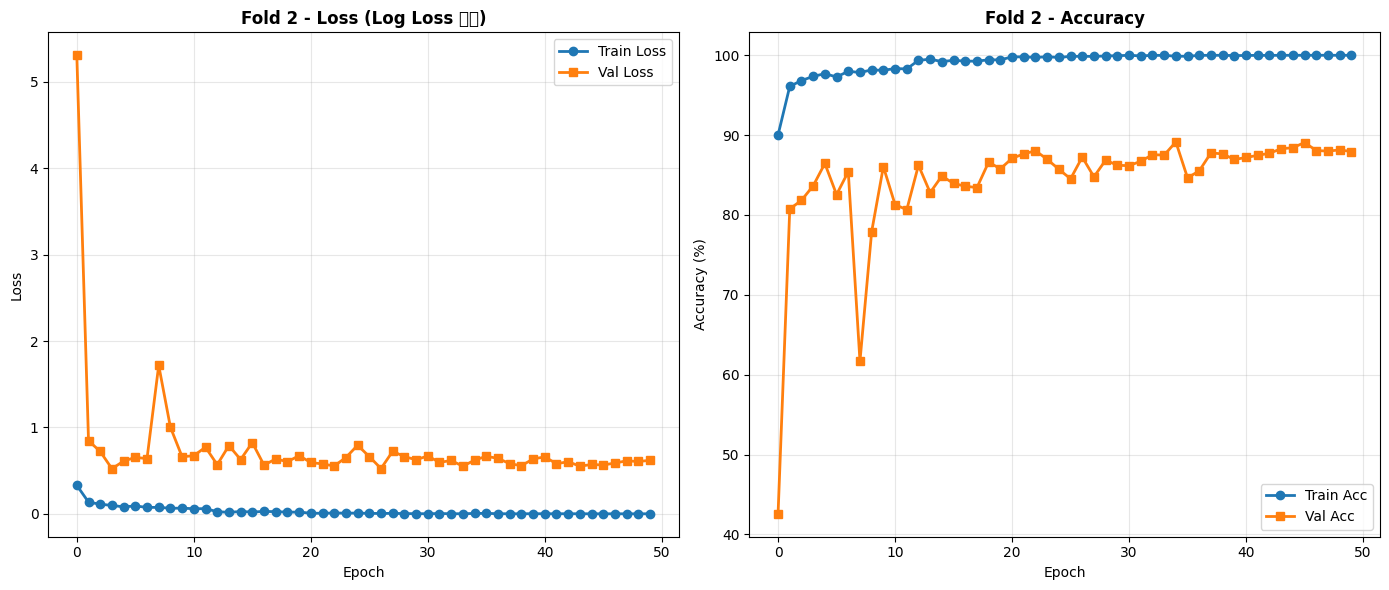

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1행 2열로 조정 (단일 폴드이므로)

for result in all_fold_results:
    fold_idx = result['fold']
    history = result['history']
    
    # Loss 그래프
    ax1 = axes[0]
    ax1.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    ax1.plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    ax1.set_title(f'Fold {fold_idx} - Loss (Log Loss 기준)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy 그래프
    ax2 = axes[1]
    ax2.plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
    ax2.plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
    ax2.set_title(f'Fold {fold_idx} - Accuracy', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./plots/loss_curve/inception_v{version}.png', dpi=300, bbox_inches='tight') # 파일명 수정
plt.show()

In [ ]:
# 학습 결과에서 Fold 2의 정보를 추출합니다.
# all_fold_results에는 현재 단 하나의 결과(Fold 2)만 들어있어야 합니다.
if not all_fold_results:
    print("🚨 오류: 학습된 폴드 결과가 없습니다. train_fold 함수를 먼저 실행하세요.")
else:
    result = all_fold_results[0]
    fold_idx = result['fold']
    model_path = result['model_path']
    
    print("\n" + "=" * 70)
    print(f"🔮 Fold {fold_idx} 단일 모델 예측 시작")
    print("=" * 70)

    # 테스트 데이터셋 생성
    # test_dir은 'data/imgs/test'여야 합니다. 
    
    test_dataset = DriverDataset(
        test_dir, driver_df, [], 
        transform=team_transform_eval, is_test=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    print(f"테스트 샘플: {len(test_dataset)}개")

    # --- 모델 로드 및 예측 ---
    
    # 1. 모델 구조 생성 (pretrained=False)
    model = timm.create_model('inception_v4', pretrained=False, num_classes=num_classes)
    
    # 2. 저장된 최저 Loss 가중치 로드
    print(f"\n📁 모델 로드 중: {model_path}...")
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Fold {fold_idx} 모델 (Epoch {checkpoint['epoch']+1}, Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}) 로드 완료.")
    except Exception as e:
        print(f"🚨 모델 로드 실패: {e}")
        # 이 시점에서 코드 실행을 멈추거나, 오류 처리를 진행할 수 있습니다.
        raise
        
    model = model.to(device)
    model.eval() # 평가 모드 설정
    
    # 3. 예측 실행
    predictions = []
    img_names = []
    
    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc=f'Fold {fold_idx} 예측'):
            images = images.to(device)
            outputs = model(images)
            
            # 4. 확률 (Softmax) 계산
            probs = torch.softmax(outputs, dim=1)
            predictions.append(probs.cpu().numpy())
            
            img_names.extend(filenames)
    
    final_predictions = np.vstack(predictions)
    print(f"\n✓ 예측 완료: {final_predictions.shape}")

    # --- Submission 파일 생성 ---
    
    # 클래스 이름을 c0, c1, ... c9로 설정
    class_cols = [f'c{i}' for i in range(num_classes)]

    submission_data = {'img': img_names}
    for i, col in enumerate(class_cols):
        submission_data[col] = final_predictions[:, i]
    
    submission = pd.DataFrame(submission_data)

    submission_file = f'inception_v{version}.csv'
    submission.to_csv("./submissions/"+submission_file, index=False)

    print("\n" + "=" * 70)
    print(f"✅ Submission 파일 생성 완료: {submission_file}")
    print(f"✅ 총 {len(submission)}개 이미지 예측")
    print("=" * 70)
    
    print("\n📋 Submission 샘플:")
    print(submission.head())


🔮 Fold 2 단일 모델 예측 시작
테스트, 데이터 79726개 이미지
테스트 샘플: 79726개

📁 모델 로드 중: best_inception_v4_fold2.pth...
✓ Fold 2 모델 (Epoch 4, Val Loss: 0.5230) 로드 완료.


Fold 2 예측: 100%|██████████| 2492/2492 [21:59<00:00,  1.89it/s]



✓ 예측 완료: (79726, 10)

✅ Submission 파일 생성 완료: inception_v4_fold2_single_model_submission.csv
✅ 총 79726개 이미지 예측

📋 Submission 샘플:
              img            c0        c1            c2            c3  \
0       img_1.jpg  4.878655e-06  0.000002  5.649306e-05  8.250891e-06   
1      img_10.jpg  3.460569e-04  0.000054  1.523180e-04  3.451189e-04   
2     img_100.jpg  3.217587e-02  0.066979  3.252032e-03  1.057807e-01   
3    img_1000.jpg  2.382241e-07  0.000002  7.378043e-08  1.456193e-08   
4  img_100000.jpg  1.891374e-03  0.000804  1.817400e-03  9.341518e-01   

             c4            c5        c6            c7        c8        c9  
0  3.761202e-06  9.989375e-01  0.000130  7.514059e-04  0.000085  0.000022  
1  3.749123e-05  9.983867e-01  0.000269  3.655562e-05  0.000341  0.000032  
2  1.030610e-01  1.033657e-02  0.021122  4.900034e-02  0.397390  0.210902  
3  6.498618e-08  9.622739e-09  0.000006  4.300710e-08  0.998222  0.001769  
4  7.034020e-03  8.308074e-05  0.013749  2.803296e-0

In [ ]:
````